In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy import stats
import seaborn as sns

In [2]:
daily_data = pd.read_csv("daily_data.csv")
daily_data.set_index("date", inplace = True)

X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [3]:
X_train.shape

(1596, 15)

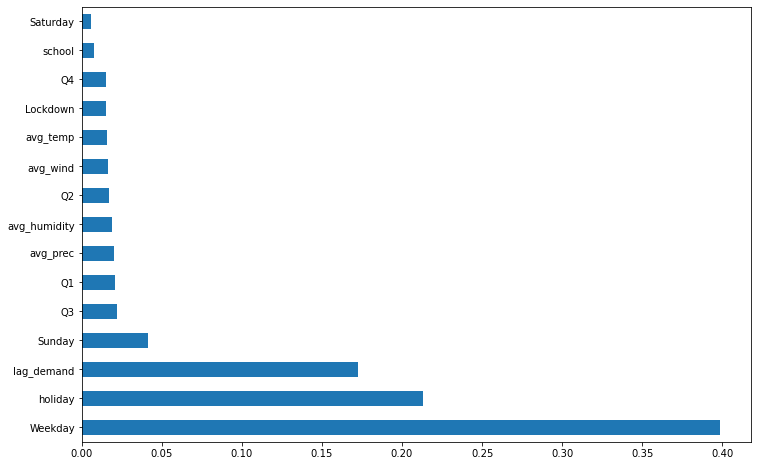

In [4]:
from xgboost import XGBRegressor
selection = XGBRegressor()
selection.fit(X_train, y_train)

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [5]:
import numpy as np
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def adj_r2(actual, pred, i):
    return 1 - ((1-r2_score(actual,pred))*(len(actual)-1)/(len(actual)-i-1))

### XG Boost Model using default params

In [6]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(seed = 20)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=20,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=20,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [7]:
y_pred= xgbr.predict(X_test)

y_pred_train = xgbr.predict(X_train)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)



from sklearn.metrics import r2_score


print("MSE for test set is: ",mse)
print("MSE for train set is: ", mse_train)


print("R2 score for test: ",r2_score(y_test,y_pred))
print("R2 score for training: ",r2_score(y_train,y_pred_train))



MSE for test set is:  1469559.9362617608
MSE for train set is:  68143.2221363972
R2 score for test:  0.7271600560020612
R2 score for training:  0.9863113270743955


### XG Boost Model with  Randomized Search CV parameter tuning

In [8]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
    
param_dist = {
        'n_estimators':range(80,300,5),
        'max_depth':range(2,15,1),
        'learning_rate':[0.01, 0.1, 0.2, 0.3],
        'subsample': np.arange(0.5, 1.0, 0.1),
        'colsample_bytree': np.arange(0.4, 1.0, 0.1),
        'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
        'min_child_weight':range(1,9,1)
        }
    


xg_random = RandomizedSearchCV(estimator=xgbr,param_distributions=param_dist,
                               cv = 3,scoring = 'neg_mean_squared_error',n_iter=300,n_jobs = -1,
                              verbose=1) 

In [9]:
for i in range(6,16):
    Xtrain_best = X_train[feat_importances.nlargest(i).index]
    xg_random.fit(Xtrain_best, y_train)
    Xtest_best = X_test[feat_importances.nlargest(i).index]
    
    y_pred= xg_random.predict(Xtest_best)

    y_pred_train = xg_random.predict(Xtrain_best)
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)



    from sklearn.metrics import r2_score
    print(i,"features: ")
    print(xg_random.best_params_)

    print("RMSE for test set is: ",(mse**(1/2)))
    print("RMSE for train set is: ", (mse_train**(1/2)))
    
    r2_adjtest = adj_r2(y_test, y_pred,i)
    r2_adjtrain = adj_r2(y_train, y_pred_train,i)
   
    print("Adjusted R2 score for test: ",r2_adjtest)
    print("Adjusted R2 score for training: ",r2_adjtrain)
    
    mape_test = mape(y_test, y_pred)
    mape_train = mape(y_train, y_pred_train)
    
   
    print("MAPE for test: ",mape_test)
    print("MAPE for training: ",mape_train)
    

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


6 features: 
{'subsample': 0.6, 'n_estimators': 135, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4}
RMSE for test set is:  1233.754753063017
RMSE for train set is:  1217.4587860115535
Adjusted R2 score for test:  0.7130704145703709
Adjusted R2 score for training:  0.7011288408117191
MAPE for test:  8.51735781954556
MAPE for training:  8.189487697501246
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.8min finished


7 features: 
{'subsample': 0.5, 'n_estimators': 85, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.6}
RMSE for test set is:  1221.9556589357899
RMSE for train set is:  1045.3818349149708
Adjusted R2 score for test:  0.7178124449127186
Adjusted R2 score for training:  0.7795049880129916
MAPE for test:  8.58593143639988
MAPE for training:  8.341659207388231
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.2min finished


8 features: 
{'subsample': 0.7, 'n_estimators': 165, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.8999999999999999}
RMSE for test set is:  1222.3790026805864
RMSE for train set is:  960.9261569723071
Adjusted R2 score for test:  0.7168928253057247
Adjusted R2 score for training:  0.8135757207660486
MAPE for test:  8.660332974794882
MAPE for training:  8.397764575194321
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.9min finished


9 features: 
{'subsample': 0.8999999999999999, 'n_estimators': 205, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7}
RMSE for test set is:  1206.273335136517
RMSE for train set is:  960.8663221584262
Adjusted R2 score for test:  0.723595203929918
Adjusted R2 score for training:  0.8134814074806682
MAPE for test:  8.647979313975267
MAPE for training:  8.398915017692683
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.6min finished


10 features: 
{'subsample': 0.7, 'n_estimators': 105, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5}
RMSE for test set is:  1191.4779949188428
RMSE for train set is:  954.11862567356
Adjusted R2 score for test:  0.7296389985642565
Adjusted R2 score for training:  0.8159758373968027
MAPE for test:  8.585408330314865
MAPE for training:  8.36146278471112
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.7min finished


11 features: 
{'subsample': 0.7, 'n_estimators': 85, 'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.5}
RMSE for test set is:  1177.9491249809678
RMSE for train set is:  696.2573791369279
Adjusted R2 score for test:  0.7350610425387879
Adjusted R2 score for training:  0.901941823330812
MAPE for test:  8.718327591976678
MAPE for training:  8.516781112125551
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.9min finished


12 features: 
{'subsample': 0.7999999999999999, 'n_estimators': 185, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4}
RMSE for test set is:  1115.5914457674496
RMSE for train set is:  837.661821944255
Adjusted R2 score for test:  0.7617533698433753
Adjusted R2 score for training:  0.8579779104277461
MAPE for test:  8.792912205547475
MAPE for training:  8.470851762702953
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.7min finished


13 features: 
{'subsample': 0.7999999999999999, 'n_estimators': 215, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.4}
RMSE for test set is:  1115.02444795215
RMSE for train set is:  871.6680929663652
Adjusted R2 score for test:  0.7613772917988015
Adjusted R2 score for training:  0.8461153901097916
MAPE for test:  8.814647265680474
MAPE for training:  8.468250780960398
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.9min finished


14 features: 
{'subsample': 0.8999999999999999, 'n_estimators': 95, 'min_child_weight': 8, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6}
RMSE for test set is:  1162.4507275140006
RMSE for train set is:  617.4889549581891
Adjusted R2 score for test:  0.7399711093737551
Adjusted R2 score for training:  0.9227273357359695
MAPE for test:  8.716436659180527
MAPE for training:  8.556324470241861
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.7min finished


15 features: 
{'subsample': 0.5, 'n_estimators': 135, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.4}
RMSE for test set is:  1152.152135063632
RMSE for train set is:  647.238384652739
Adjusted R2 score for test:  0.7438911392921506
Adjusted R2 score for training:  0.9150485467782448
MAPE for test:  8.88487678232568
MAPE for training:  8.583807768366201


In [10]:
# We Get the best scores and accuracy with 13 features

### Final  XG Boost Regression Model

In [11]:
import xgboost as xgb

regressor = xgb.XGBRegressor(subsample = 0.7999999999999999, n_estimators = 215, min_child_weight = 4, max_depth=3, 
                             learning_rate= 0.1, colsample_bytree = 0.8999999999999999, colsample_bylevel = 0.4)

Xtrain_best = X_train[feat_importances.nlargest(13).index]
regressor.fit(Xtrain_best, y_train)
Xtest_best = X_test[feat_importances.nlargest(13).index]
    
y_pred= regressor.predict(Xtest_best)


    
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

print("RMSE for test set is: ",(mse**(1/2)))
  
r2_adjtest = adj_r2(y_test, y_pred,13)

   
print("Adjusted R2 score for test: ",r2_adjtest)

mape_test = mape(y_test, y_pred)

print("MAPE for test: ",mape_test)


RMSE for test set is:  1144.9493345593596
Adjusted R2 score for test:  0.748397165890295
MAPE for test:  8.804296072209432


<Figure size 1440x1440 with 0 Axes>

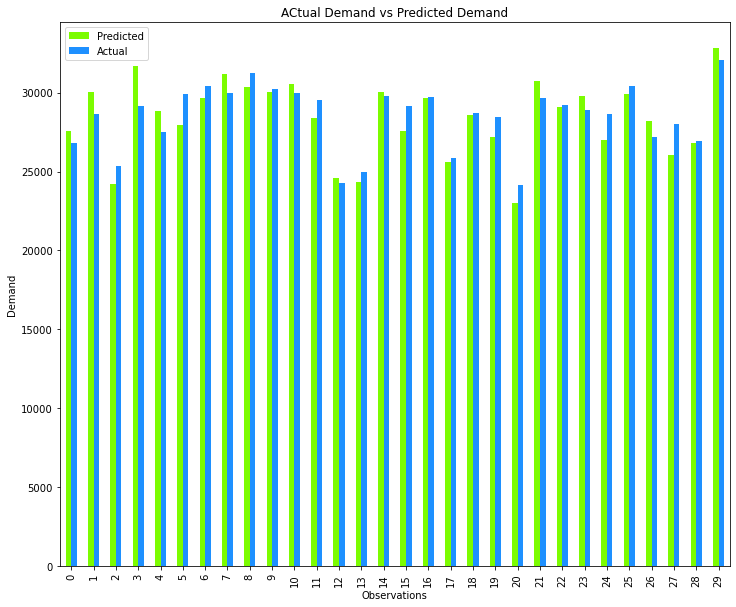

In [22]:
plt.figure(figsize= (20,20))
df = pd.concat([y_test, pd.DataFrame(y_pred)], axis = 1)
df.columns = {"Actual","Predicted"}

df.head(30).plot(kind='bar',figsize=(12,10),color = {"dodgerblue","lawngreen"})
plt.title("ACtual Demand vs Predicted Demand")
plt.xlabel("Observations")
plt.ylabel("Demand")
plt.show()